# About activity_descriptors_detector.ipynb

This notebook detects different aspects of activities from log files.
This is a work in progress :)

In [18]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
from tabulate import tabulate
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10,6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Grabbing log data and preparing df with results

In [2]:
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

In [11]:
ids = get_students_to_analyze()
results = pd.DataFrame(index =ids, columns = ['use table','use graph','exploration duration','activity duration'])
results = results.fillna(0)
results.index.name = 'studentid'
results[['use table']] = results[['use table']].astype(bool)
results[['use graph']] = results[['use graph']].astype(bool)
results[['exploration duration']] = results[['exploration duration']].astype(float)
results[['activity duration']] = results[['activity duration']].astype(float)
metadf = get_student_metadata()
results = results.merge(metadf[['activity order']],how='left',left_index=True,right_index=True)
results_light = results.copy()
results_caps = results.copy()
results_caps.head()

,use table,use graph,exploration duration,activity duration,activity order
10127163,False,False,0.0,0.0,LC
10192168,False,False,0.0,0.0,CL
10232160,False,False,0.0,0.0,LC
10375163,False,False,0.0,0.0,CL
10420167,False,False,0.0,0.0,CL
10537160,False,False,0.0,0.0,CL
10561164,False,False,0.0,0.0,CL
10708152,False,False,0.0,0.0,CL
10866146,False,False,0.0,0.0,CL
10908162,False,False,0.0,0.0,LC


# Build dectectors
## Use table/graph

In [4]:
def get_use_table(df):
    tables = set(df['Table'])
    for i,t in enumerate(tables):
        if len(t)>10:
            return True
    else:
        return False

def get_use_graph(df):
    tables = set(df['Table'])
    for i,t in enumerate(tables):
        table = read_table(t)
        points = get_pts(table,in_graph=True)
        if len(points)>0:
            return True
    else:
        return False

In [5]:
def get_exploration_duration(df):
    times = list(df[df['Event']=='recording data']['Time'])
    if len(times)>=2:
        times.sort()
        #return the time of the second record
        return times[1]
    else:
        #else, return last time stamp
        return list(df.sort_values(by='Time')['Time'])[-1]

def get_activity_duration(df):
    return list(df.sort_values(by='Time')['Time'])[-1]

In [12]:
for sim,results in [('beers',results_light),('capacitor',results_caps)]:
    log_files = log_files_per_sim[sim]
    for sid,logs in log_files.iteritems():
        use_table = False
        use_graph = False
        exploration_duration = 0
        activity_duration= 0
        for log in logs:
            df = prep_parsing_data(log)
            if not df.empty:
                exploration_duration = max(exploration_duration, get_exploration_duration(df))
                activity_duration += get_activity_duration(df)
                if get_use_table(df):
                    use_table = True
                    if get_use_graph(df):
                        use_graph = True

        results.set_value(sid, 'exploration duration',exploration_duration)
        results.set_value(sid, 'activity duration',activity_duration)
        results.set_value(sid, 'use table',use_table)
        results.set_value(sid, 'use graph',use_graph)

## Per sim, how much are the graph and table used?

In [19]:
p = [['','use table','use graph']]
p.append(['light',sum(results_light['use table'])/float(len(results_light)),sum(results_light['use graph'])/float(len(results_light))])
p.append(['caps',sum(results_caps['use table'])/float(len(results_caps)),sum(results_caps['use graph'])/float(len(results_caps))])
print tabulate(p)

-----  --------------  --------------
       use table       use graph
light  0.953020134228  0.798657718121
caps   0.93288590604   0.651006711409
-----  --------------  --------------


## How long are activities?

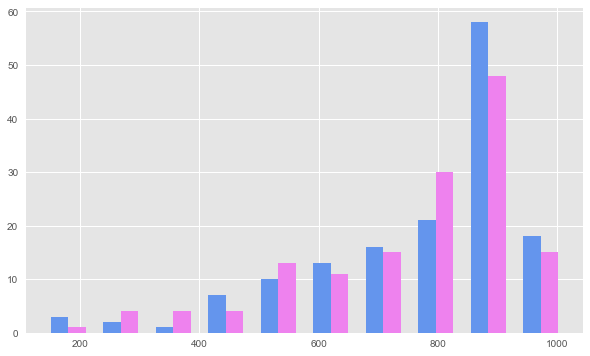

In [28]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(results_light['activity duration'])
b_heights, b_bins = np.histogram(results_caps['activity duration'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='violet')
plt.legend()

## How long do students explore in each sim?
### Overall

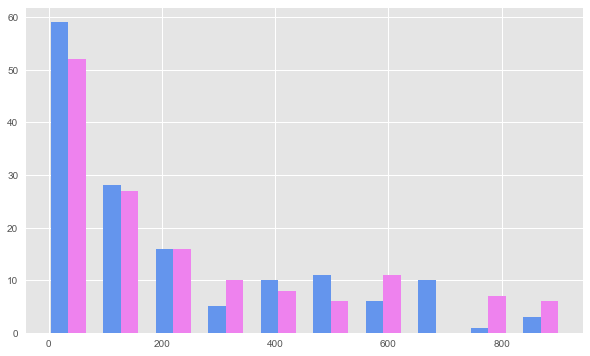

In [29]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(results_light['exploration duration'])
b_heights, b_bins = np.histogram(results_caps['exploration duration'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='violet')
plt.legend()

### by order

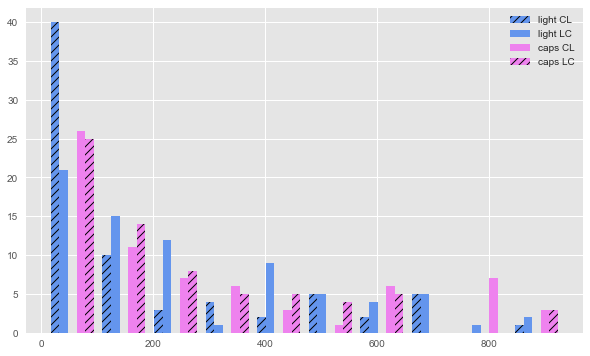

In [43]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(results_light[results_light['activity order']=='CL']['exploration duration'])
b_heights, b_bins = np.histogram(results_light[results_light['activity order']=='LC']['exploration duration'], bins=a_bins)
c_heights, c_bins = np.histogram(results_caps[results_light['activity order']=='CL']['exploration duration'], bins=a_bins)
d_heights, d_bins = np.histogram(results_caps[results_light['activity order']=='LC']['exploration duration'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue',hatch="///",label='light CL')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='cornflowerblue',label='light LC')
ax.bar(c_bins[:-1]+width*3, c_heights, width=width, facecolor='violet',label='caps CL')
ax.bar(d_bins[:-1]+width*4, d_heights, width=width, facecolor='violet',hatch="///",label='caps LC')
plt.legend()

In [51]:
from scipy.stats import mannwhitneyu
p = [['','CL','LC','mannwhitney U','p-value']]
l_CL = results_light[results_light['activity order']=='CL']['exploration duration'].values
l_LC = results_light[results_light['activity order']=='LC']['exploration duration'].values
c_CL = results_caps[results_caps['activity order']=='CL']['exploration duration'].values
c_LC = results_caps[results_caps['activity order']=='LC']['exploration duration'].values
m,pv = mannwhitneyu(l_CL,l_LC)
p.append(['light',str(np.mean(l_CL))+'+-'+str(np.std(l_CL)),str(np.mean(l_LC))+'+-'+str(np.std(l_LC)),m,pv])
m,pv = mannwhitneyu(c_CL,c_LC)
p.append(['caps',str(np.mean(c_CL))+'+-'+str(np.std(c_CL)),str(np.mean(c_LC))+'+-'+str(np.std(c_LC)),m,pv])
print tabulate(p)

-----  ----------------------------  ----------------------------  -------------  ----------------
       CL                            LC                            mannwhitney U  p-value
light  212.285541667+-228.052367311  292.752116883+-236.200251906  2007.0         0.00184157981409
caps   319.349958333+-287.698960446  229.177+-223.417427032        2203.0         0.0154036480515
-----  ----------------------------  ----------------------------  -------------  ----------------


d:\applications\anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


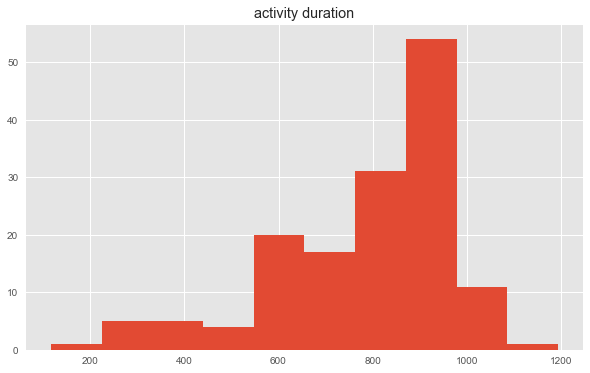

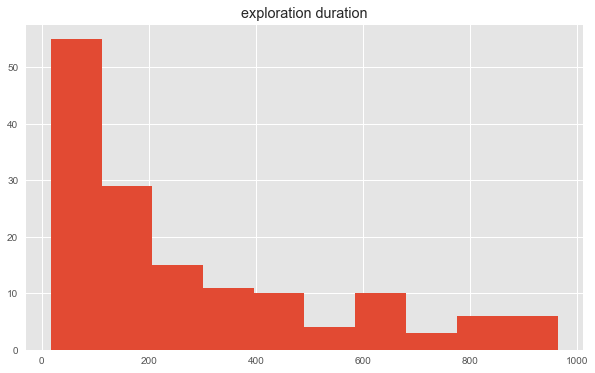

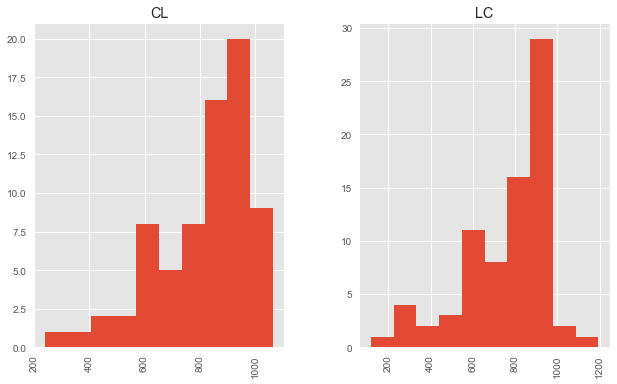

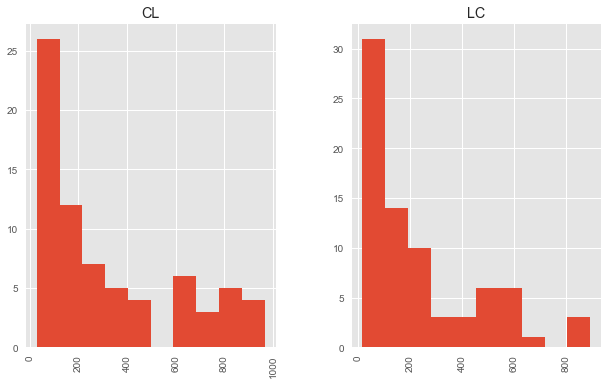

In [9]:
am

a
results.hist(column='activity duration')
results.hist(column='exploration duration')
results.hist(column='activity duration',by='activity order')
results.hist(column='exploration duration',by='activity order')
plt.legend()